NaN counts before fixing:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast     0
label                 0
dtype: int64

NaN counts after fixing:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast    

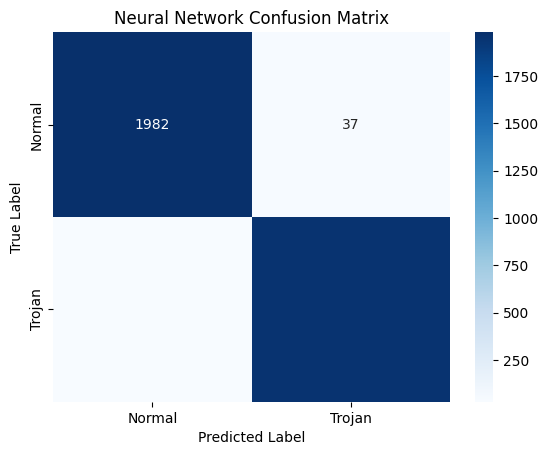

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Load and Preprocess Data
df = pd.read_csv("IL_T1300_cleaned1.csv")
print("NaN counts before fixing:\n", df.isnull().sum())

# Fill missing values
df['spectral_contrast'].fillna(df['spectral_contrast'].mean(), inplace=True)
print("\nNaN counts after fixing:\n", df.isnull().sum())

# Split into normal and anomaly
df_normal = df[df['label'] == 0].copy()
df_anomaly = df[df['label'] == 1].copy()

# Feature extraction
def extract_features_labels(df_in):
    X = df_in.drop(columns=['label']).values
    y = df_in['label'].values
    return X, y

X, y = extract_features_labels(df)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, rf_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, rf_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, rf_pred) * 100:.2f}%")

# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.001, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
print("\nGradient Boosting Performance:")
print(f"Accuracy: {accuracy_score(y_test, gb_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, gb_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, gb_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, gb_pred) * 100:.2f}%")

# 3. Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print("\nNaive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, nb_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, nb_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, nb_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, nb_pred) * 100:.2f}%")

# 4. Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
model = NeuralNet(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
patience = 10
counter = 0

# Training the neural network
for epoch in range(200):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Early stopping
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train_tensor)
        _, val_pred = torch.max(val_outputs, 1)
        val_acc = accuracy_score(y_train, val_pred.numpy())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print("Early stopping activated.")
            break

# Testing the neural network
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_pred = torch.max(test_outputs, 1)

print("\nNeural Network Performance:")
print(f"Accuracy: {accuracy_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, test_pred.numpy()) * 100:.2f}%")

# Confusion Matrix for Neural Network
cm = confusion_matrix(y_test, test_pred.numpy())
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Trojan"], yticklabels=["Normal", "Trojan"])
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


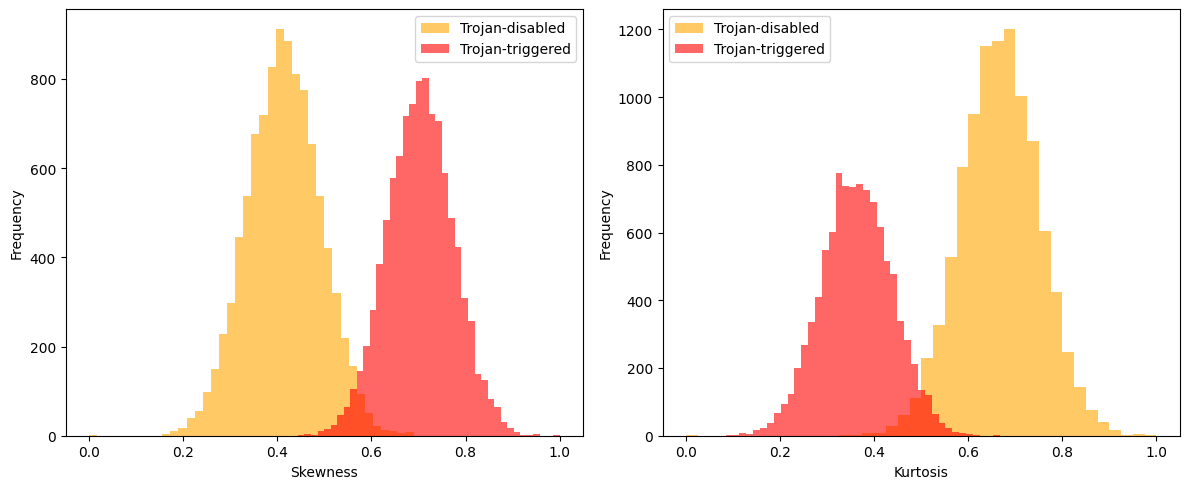

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('IL_T1300_cleaned1.csv')

# Define the features
features = ['Skewness', 'Kurtosis']

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms for both features
for i, feature in enumerate(features):
    ax = axes[i]
    ax.hist(df[df['label'] == 0][feature], bins=40, alpha=0.6, label='Trojan-disabled', color='orange')
    ax.hist(df[df['label'] == 1][feature], bins=40, alpha=0.6, label='Trojan-triggered', color='red')
    #ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()

# Save the figure
plt.savefig('T1300_skewness_kurtosis_distributions.png', dpi=300)

plt.show()
